### ***Importing libraries***

In [1]:
# 1
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns

import keras
from keras.models import Sequential, load_model
from keras.layers import Dense, Conv2D , MaxPool2D , Flatten , Dropout 
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam
from keras.regularizers import l1


from sklearn.metrics import classification_report,confusion_matrix

import tensorflow as tf

import cv2
import os

import numpy as np
from tqdm import tqdm

import gc
import imblearn



/usr/local/lib/python3.7/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)


### ***Connecting to drive***

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### ***Defining paths***

In [2]:
# 2
train_path = '/content/drive/MyDrive/Colab Notebooks/training_set/training_set'
test_path = '/content/drive/MyDrive/Colab Notebooks/test_set/test_set'
categories = ['cats', 'dogs']
output_path = '/content/drive/MyDrive/Colab Notebooks/output/original'
train_gen_path = '/content/drive/MyDrive/Colab Notebooks/training_set/gen'

## ***Preprocessing:***

### ***Saving images weights and heights***

In [ ]:
train_images_widths = []
train_images_heights = []

test_images_widths = []
test_images_heights = []

### train images
for cat in categories:
  files = os.listdir(os.path.join(train_path, cat))
  for file in tqdm(files):
    path = os.path.join(train_path, cat, file)
    img = mpimg.imread(path)
    train_images_widths.append(img.shape[0])
    train_images_heights.append(img.shape[1])

### test images
for cat in categories:
  files = os.listdir(os.path.join(test_path, cat))
  for file in tqdm(files):
    path = os.path.join(test_path, cat, file)
    img = mpimg.imread(path)
    test_images_widths.append(img.shape[0])
    test_images_heights.append(img.shape[1])

In [ ]:
np.save(os.path.join(output_path, 'train_images_widths.npy'), train_images_widths)
np.save(os.path.join(output_path, 'train_images_heights.npy'), train_images_heights)

np.save(os.path.join(output_path, 'test_images_widths.npy'), test_images_widths)
np.save(os.path.join(output_path, 'test_images_heights.npy'), test_images_heights)

### ***Finding Average of Heights and Widths***

In [3]:
# 3
w1 = np.load(os.path.join(output_path, 'train_images_widths.npy'))
w2 = np.load(os.path.join(output_path, 'test_images_widths.npy'))

h1 = np.load(os.path.join(output_path, 'train_images_heights.npy'))
h2 = np.load(os.path.join(output_path, 'test_images_heights.npy'))

In [4]:
# 4
w_avg  = int(((np.sum(w1)+np.sum(w2))/(w1.shape[0]+w2.shape[0]))/3)
h_avg  = int(((np.sum(h1)+np.sum(h2))/(h1.shape[0]+h2.shape[0]))/3)
print(f"Average Height to Set For All Images = {h_avg}")
print(f"Average Width to Set For All Images  = {w_avg}")

Average Height to Set For All Images = 134
Average Width to Set For All Images  = 120


### ***Setting up Dataset:***

In [5]:
# 5
# for neural
labels = ['cats', 'dogs']
img_size = (w_avg,h_avg)

In [ ]:
# 5
# for cnn
labels = ['cats', 'dogs']
img_size = (128,128)

In [ ]:
def get_data(data_dir):
    data = [] 
    for label in labels: 
        path = os.path.join(data_dir, label)
        class_num = labels.index(label)
        for img in os.listdir(path):
            try:
                img_arr = cv2.imread(os.path.join(path, img))[...,::-1] #convert BGR to RGB format
                resized_arr = cv2.resize(img_arr, img_size) # Reshaping images to our intended size
                data.append([resized_arr, class_num])
            except Exception as e:
                print(e)
    return np.array(data)

In [ ]:
train = get_data(train_path)
val = get_data(test_path)

In [ ]:
x_train = []
y_train = []
x_val = []
y_val = []

for feature, label in train:
  x_train.append(feature)
  y_train.append(label)

for feature, label in val:
  x_val.append(feature)
  y_val.append(label)

x_train = np.array(x_train) / 255
x_val = np.array(x_val) / 255
x_train.reshape(-1, img_size, img_size, 1)
y_train = np.array(y_train)

x_val.reshape(-1, img_size, img_size, 1)
y_val = np.array(y_val)

In [6]:
# 6
# for neural

x_train = np.load(os.path.join(output_path, 'train_X.npy'), allow_pickle=True)
y_train = np.load(os.path.join(output_path, 'train_Y.npy'), allow_pickle=True)
x_val   = np.load(os.path.join(output_path, 'test_X.npy'), allow_pickle=True)
y_val   = np.load(os.path.join(output_path, 'test_Y.npy'), allow_pickle=True)

In [ ]:
# 6
# for cnn

x_train = np.load(os.path.join(output_path, 'train_sq_X.npy'), allow_pickle=True)
y_train = np.load(os.path.join(output_path, 'train_sq_Y.npy'), allow_pickle=True)
x_val   = np.load(os.path.join(output_path, 'test_sq_X.npy'), allow_pickle=True)
y_val   = np.load(os.path.join(output_path, 'test_sq_Y.npy'), allow_pickle=True)

### ***Data Augmentation:***

In [ ]:
train_datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range = 30,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.2, # Randomly zoom image 
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip = True,  # randomly flip images
        vertical_flip=False)  # randomly flip images

In [ ]:
train_generator = train_datagen.flow(x_train, y_train)

In [ ]:
x_train_gen = []
y_train_gen = []
train_generator.reset()
print(train_generator.__len__())
for i in range(train_generator.__len__()):
   a, b = train_generator.next()
   x_train_gen.append(a)
   y_train_gen.append(b)
x_train_gen=np.array(x_train_gen)
y_train_gen=np.array(y_train_gen)
print(x_train_gen.shape)
print(y_train_gen.shape)

(250, 32, 128, 128, 3)
(250, 32)


In [ ]:
y_train_gen_reshaped = y_train_gen.reshape(250*32,)
x_train_gen_reshaped = x_train_gen.reshape(250*32, 128, 128, 3)

In [ ]:
x_train = np.concatenate((x_train, x_train_gen_reshaped))

In [ ]:
y_train = np.concatenate((y_train, y_train_gen_reshaped))

In [ ]:
# np.save(os.path.join(output_path, 'train_sq_X.npy'), x_train)
# np.save(os.path.join(output_path, 'train_sq_Y.npy'), y_train)

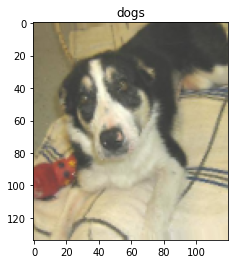

In [ ]:
plt.imshow(x_train_gen_reshaped[0])
plt.title(labels[y_train_gen_reshaped[0]])
plt.show()


##  **الف)** 

### ***Base model:***

In [ ]:
#NN
model = Sequential()
model.add(Flatten(input_shape=(134,120,3)))

model.add(Dense(512, activation="relu",activity_regularizer=l1(0.001)))
model.add(Dropout(0.2))

model.add(Dense(512, activation="relu",activity_regularizer=l1(0.001)))
model.add(Dropout(0.2))

model.add(Dense(2, activation="softmax"))

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 48240)             0         
_________________________________________________________________
dense (Dense)                (None, 512)               24699392  
_________________________________________________________________
dropout (Dropout)            (None, 512)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 512)               262656    
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 2)                 1026      
Total params: 24,963,074
Trainable params: 24,963,074
Non-trainable params: 0
____________________________________________

In [ ]:
opt = Adam(learning_rate=0.000001)#0.000001
model.compile(optimizer = opt , loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True) , metrics = ['accuracy'])

In [ ]:
history = model.fit(x_train,y_train,epochs = 128 ,batch_size=64, validation_data = (x_val, y_val))

Epoch 1/128


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/backend.py:4930: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  '"`sparse_categorical_crossentropy` received `from_logits=True`, but '


250/250 [==============================] - 19s 15ms/step - loss: 0.8518 - accuracy: 0.5214 - val_loss: 0.7079 - val_accuracy: 0.5830
Epoch 2/128
250/250 [==============================] - 3s 12ms/step - loss: 0.7034 - accuracy: 0.5643 - val_loss: 0.6963 - val_accuracy: 0.5515
Epoch 3/128
250/250 [==============================] - 3s 12ms/step - loss: 0.6947 - accuracy: 0.5620 - val_loss: 0.6938 - val_accuracy: 0.5615
Epoch 4/128
250/250 [==============================] - 3s 12ms/step - loss: 0.6918 - accuracy: 0.5796 - val_loss: 0.6922 - val_accuracy: 0.5575
Epoch 5/128
250/250 [==============================] - 3s 12ms/step - loss: 0.6898 - accuracy: 0.5714 - val_loss: 0.6908 - val_accuracy: 0.5710
Epoch 6/128
250/250 [==============================] - 3s 13ms/step - loss: 0.6885 - accuracy: 0.5891 - val_loss: 0.6890 - val_accuracy: 0.5825
Epoch 7/128
250/250 [==============================] - 3s 12ms/step - loss: 0.6861 - accuracy: 0.5928 - val_loss: 0.6867 - val_accuracy: 0.6105
Epo

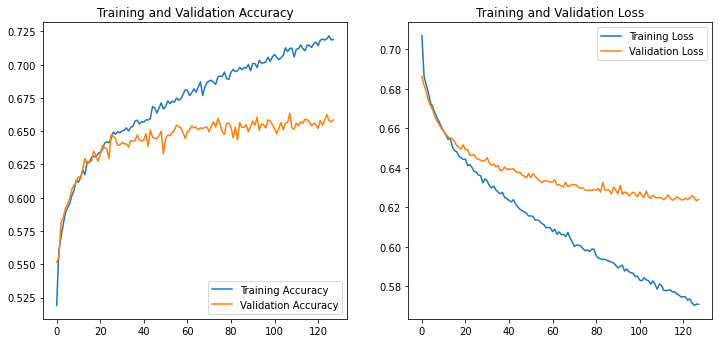

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(128)

plt.figure(figsize=(12, 12))
plt.subplot(2, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [ ]:
predictions = model.predict_classes(x_val)
predictions = predictions.reshape(1,-1)[0]
print(classification_report(y_val, predictions, target_names = ['Cats (Class 0)','Dogs (Class 1)']))

/usr/local/lib/python3.7/dist-packages/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


                precision    recall  f1-score   support

Cats (Class 0)       0.70      0.62      0.66      1000
Dogs (Class 1)       0.66      0.74      0.70      1000

      accuracy                           0.68      2000
     macro avg       0.68      0.68      0.68      2000
  weighted avg       0.68      0.68      0.68      2000



In [ ]:
model.save(os.path.join(output_path, 'models', '02_base-model_0-000001_64_128.h5'))

### ***Solution to fixing overfitting: Simplifying***

In [ ]:
#NN
model = Sequential()
model.add(Flatten(input_shape=(134,120,3)))
# model.add(Flatten(input_shape=(128,128,3)))


model.add(Dense(50, activation="relu",activity_regularizer=l1(0.001)))
model.add(Dropout(0.2))



model.add(Dense(2, activation="softmax"))

model.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_7 (Flatten)          (None, 48240)             0         
_________________________________________________________________
dense_15 (Dense)             (None, 50)                2412050   
_________________________________________________________________
dropout_8 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense_16 (Dense)             (None, 2)                 102       
Total params: 2,412,152
Trainable params: 2,412,152
Non-trainable params: 0
_________________________________________________________________


In [ ]:
opt = Adam(learning_rate=0.000001)#0.000001
model.compile(optimizer = opt , loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True) , metrics = ['accuracy'])

In [ ]:
history = model.fit(x_train,y_train,epochs = 128 ,batch_size=64, validation_data = (x_val, y_val))

Epoch 1/128


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/backend.py:4930: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  '"`sparse_categorical_crossentropy` received `from_logits=True`, but '


250/250 [==============================] - 3s 9ms/step - loss: 0.7503 - accuracy: 0.4958 - val_loss: 0.6878 - val_accuracy: 0.5475
Epoch 2/128
250/250 [==============================] - 2s 8ms/step - loss: 0.6909 - accuracy: 0.5508 - val_loss: 0.6801 - val_accuracy: 0.5830
Epoch 3/128
250/250 [==============================] - 2s 8ms/step - loss: 0.6848 - accuracy: 0.5577 - val_loss: 0.6765 - val_accuracy: 0.5825
Epoch 4/128
250/250 [==============================] - 2s 8ms/step - loss: 0.6810 - accuracy: 0.5731 - val_loss: 0.6742 - val_accuracy: 0.5845
Epoch 5/128
250/250 [==============================] - 2s 8ms/step - loss: 0.6769 - accuracy: 0.5782 - val_loss: 0.6708 - val_accuracy: 0.5945
Epoch 6/128
250/250 [==============================] - 2s 8ms/step - loss: 0.6735 - accuracy: 0.5874 - val_loss: 0.6687 - val_accuracy: 0.5935
Epoch 7/128
250/250 [==============================] - 2s 8ms/step - loss: 0.6689 - accuracy: 0.5981 - val_loss: 0.6650 - val_accuracy: 0.6085
Epoch 8/128

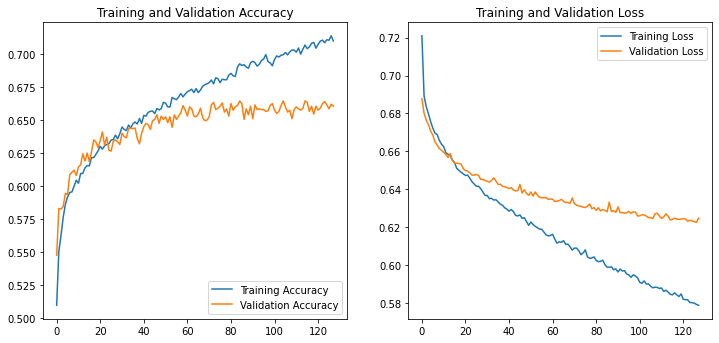

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(128)

plt.figure(figsize=(12, 12))
plt.subplot(2, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [ ]:
predictions = model.predict_classes(x_val)
predictions = predictions.reshape(1,-1)[0]
print(classification_report(y_val, predictions, target_names = ['Cats (Class 0)','Dogs (Class 1)']))

/usr/local/lib/python3.7/dist-packages/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


                precision    recall  f1-score   support

Cats (Class 0)       0.65      0.70      0.67      1000
Dogs (Class 1)       0.67      0.62      0.64      1000

      accuracy                           0.66      2000
     macro avg       0.66      0.66      0.66      2000
  weighted avg       0.66      0.66      0.66      2000



In [ ]:
model.save(os.path.join(output_path, 'models', '03_part-a-simple_0-000001_64_128.h5'))

##  **ب)** 

### ***Impact Of Learning Rate on Convergence:***

Epoch 1/128


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/backend.py:4930: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  '"`sparse_categorical_crossentropy` received `from_logits=True`, but '


250/250 - 3s - loss: 0.7010 - accuracy: 0.5315 - val_loss: 0.6832 - val_accuracy: 0.5720
Epoch 2/128
250/250 - 2s - loss: 0.6847 - accuracy: 0.5570 - val_loss: 0.6799 - val_accuracy: 0.5820
Epoch 3/128
250/250 - 2s - loss: 0.6793 - accuracy: 0.5748 - val_loss: 0.6755 - val_accuracy: 0.5915
Epoch 4/128
250/250 - 2s - loss: 0.6755 - accuracy: 0.5857 - val_loss: 0.6718 - val_accuracy: 0.6035
Epoch 5/128
250/250 - 2s - loss: 0.6736 - accuracy: 0.5885 - val_loss: 0.6702 - val_accuracy: 0.6110
Epoch 6/128
250/250 - 2s - loss: 0.6709 - accuracy: 0.5944 - val_loss: 0.6691 - val_accuracy: 0.6075
Epoch 7/128
250/250 - 2s - loss: 0.6679 - accuracy: 0.6004 - val_loss: 0.6657 - val_accuracy: 0.6105
Epoch 8/128
250/250 - 2s - loss: 0.6665 - accuracy: 0.6022 - val_loss: 0.6657 - val_accuracy: 0.6075
Epoch 9/128
250/250 - 2s - loss: 0.6636 - accuracy: 0.6062 - val_loss: 0.6631 - val_accuracy: 0.6135
Epoch 10/128
250/250 - 2s - loss: 0.6620 - accuracy: 0.6113 - val_loss: 0.6615 - val_accuracy: 0.6185
E

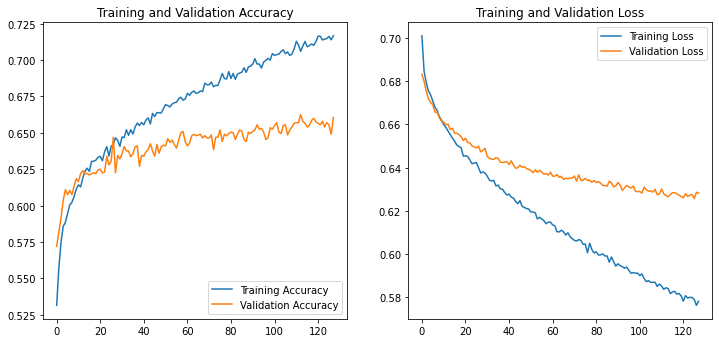

Epoch 1/128
250/250 - 3s - loss: 0.6918 - accuracy: 0.5392 - val_loss: 0.6807 - val_accuracy: 0.5775
Epoch 2/128
250/250 - 2s - loss: 0.6788 - accuracy: 0.5766 - val_loss: 0.6711 - val_accuracy: 0.6075
Epoch 3/128
250/250 - 2s - loss: 0.6714 - accuracy: 0.5806 - val_loss: 0.6636 - val_accuracy: 0.6200
Epoch 4/128
250/250 - 2s - loss: 0.6666 - accuracy: 0.5906 - val_loss: 0.6609 - val_accuracy: 0.6180
Epoch 5/128
250/250 - 2s - loss: 0.6622 - accuracy: 0.6040 - val_loss: 0.6570 - val_accuracy: 0.6190
Epoch 6/128
250/250 - 2s - loss: 0.6589 - accuracy: 0.6063 - val_loss: 0.6576 - val_accuracy: 0.6120
Epoch 7/128
250/250 - 2s - loss: 0.6568 - accuracy: 0.6087 - val_loss: 0.6566 - val_accuracy: 0.6260
Epoch 8/128
250/250 - 2s - loss: 0.6542 - accuracy: 0.6136 - val_loss: 0.6487 - val_accuracy: 0.6390
Epoch 9/128
250/250 - 2s - loss: 0.6509 - accuracy: 0.6178 - val_loss: 0.6584 - val_accuracy: 0.6205
Epoch 10/128
250/250 - 2s - loss: 0.6469 - accuracy: 0.6244 - val_loss: 0.6471 - val_accura

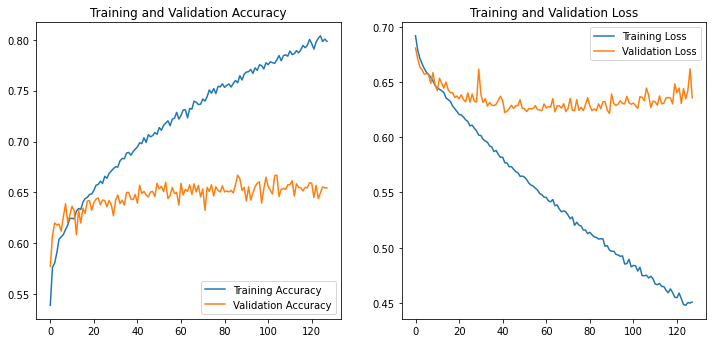

Epoch 1/128
250/250 - 2s - loss: 0.7157 - accuracy: 0.4964 - val_loss: 0.6931 - val_accuracy: 0.5000
Epoch 2/128
250/250 - 2s - loss: 0.6932 - accuracy: 0.5000 - val_loss: 0.6931 - val_accuracy: 0.5000
Epoch 3/128
250/250 - 2s - loss: 0.6932 - accuracy: 0.5000 - val_loss: 0.6931 - val_accuracy: 0.5000
Epoch 4/128
250/250 - 2s - loss: 0.6932 - accuracy: 0.4985 - val_loss: 0.6931 - val_accuracy: 0.5000
Epoch 5/128
250/250 - 2s - loss: 0.6932 - accuracy: 0.4955 - val_loss: 0.6931 - val_accuracy: 0.5000
Epoch 6/128
250/250 - 2s - loss: 0.6932 - accuracy: 0.4972 - val_loss: 0.6931 - val_accuracy: 0.5000
Epoch 7/128
250/250 - 2s - loss: 0.6932 - accuracy: 0.4924 - val_loss: 0.6931 - val_accuracy: 0.5000
Epoch 8/128
250/250 - 2s - loss: 0.6932 - accuracy: 0.5000 - val_loss: 0.6931 - val_accuracy: 0.5000
Epoch 9/128
250/250 - 2s - loss: 0.6932 - accuracy: 0.4976 - val_loss: 0.6931 - val_accuracy: 0.5000
Epoch 10/128
250/250 - 2s - loss: 0.6932 - accuracy: 0.4975 - val_loss: 0.6931 - val_accura

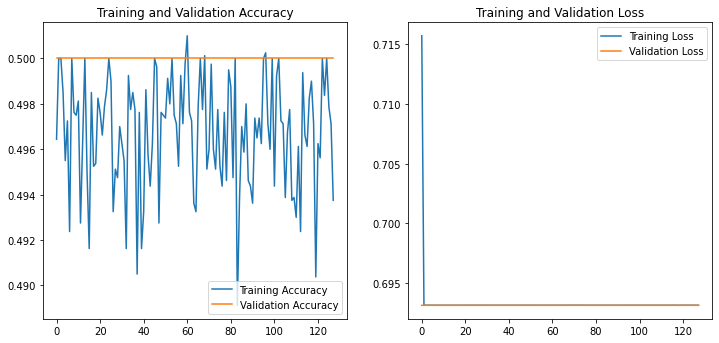

Epoch 1/128
250/250 - 3s - loss: 1.2200 - accuracy: 0.5001 - val_loss: 0.6931 - val_accuracy: 0.5000
Epoch 2/128
250/250 - 2s - loss: 0.6930 - accuracy: 0.4939 - val_loss: 0.6931 - val_accuracy: 0.5000
Epoch 3/128
250/250 - 2s - loss: 0.6932 - accuracy: 0.5025 - val_loss: 0.6932 - val_accuracy: 0.5000
Epoch 4/128
250/250 - 2s - loss: 0.6932 - accuracy: 0.4981 - val_loss: 0.6931 - val_accuracy: 0.5000
Epoch 5/128
250/250 - 2s - loss: 0.6932 - accuracy: 0.4976 - val_loss: 0.6932 - val_accuracy: 0.5000
Epoch 6/128
250/250 - 2s - loss: 0.6932 - accuracy: 0.4913 - val_loss: 0.6931 - val_accuracy: 0.5000
Epoch 7/128
250/250 - 2s - loss: 0.6932 - accuracy: 0.5005 - val_loss: 0.6932 - val_accuracy: 0.5000
Epoch 8/128
250/250 - 2s - loss: 0.6932 - accuracy: 0.4938 - val_loss: 0.6931 - val_accuracy: 0.5000
Epoch 9/128
250/250 - 2s - loss: 0.6932 - accuracy: 0.4970 - val_loss: 0.6932 - val_accuracy: 0.5000
Epoch 10/128
250/250 - 2s - loss: 0.6932 - accuracy: 0.5023 - val_loss: 0.6932 - val_accura

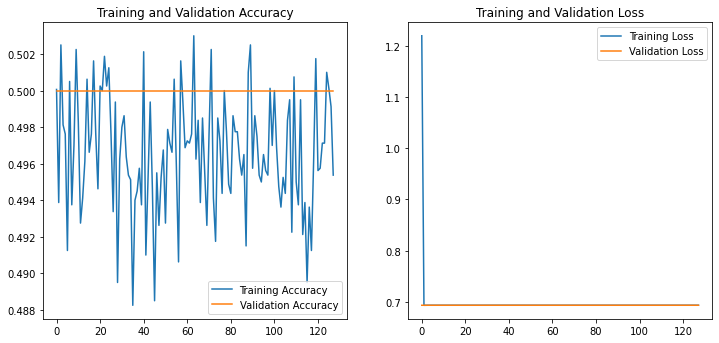

Epoch 1/128
250/250 - 3s - loss: 3614.9143 - accuracy: 0.5028 - val_loss: 0.6952 - val_accuracy: 0.5000
Epoch 2/128
250/250 - 2s - loss: 0.7190 - accuracy: 0.4997 - val_loss: 0.7558 - val_accuracy: 0.5000
Epoch 3/128
250/250 - 2s - loss: 0.7058 - accuracy: 0.5051 - val_loss: 0.7143 - val_accuracy: 0.5000
Epoch 4/128
250/250 - 2s - loss: 0.7168 - accuracy: 0.4958 - val_loss: 0.7468 - val_accuracy: 0.5000
Epoch 5/128
250/250 - 2s - loss: 0.7125 - accuracy: 0.5046 - val_loss: 0.6959 - val_accuracy: 0.5000
Epoch 6/128
250/250 - 2s - loss: 0.7123 - accuracy: 0.4983 - val_loss: 0.7026 - val_accuracy: 0.5000
Epoch 7/128
250/250 - 2s - loss: 0.7133 - accuracy: 0.5033 - val_loss: 0.7067 - val_accuracy: 0.5000
Epoch 8/128
250/250 - 2s - loss: 0.7121 - accuracy: 0.4958 - val_loss: 0.7002 - val_accuracy: 0.5000
Epoch 9/128
250/250 - 2s - loss: 0.7184 - accuracy: 0.4930 - val_loss: 0.7766 - val_accuracy: 0.5000
Epoch 10/128
250/250 - 2s - loss: 0.7111 - accuracy: 0.4930 - val_loss: 0.7385 - val_acc

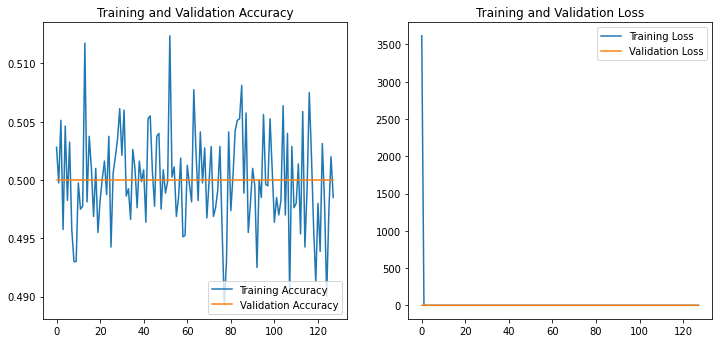

In [ ]:
rates = [0.000001, 0.00001, 0.0001, 0.001, 1]


for i in rates:
  model = Sequential()
  model.add(Flatten(input_shape=(134,120,3)))
  model.add(Dense(50, activation="relu",activity_regularizer=l1(0.001)))
  model.add(Dropout(0.2))
  model.add(Dense(2, activation="softmax"))

  opt = Adam(learning_rate=i)
  model.compile(optimizer = opt , loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True) , metrics = ['accuracy'])
  history = model.fit(x_train,y_train,epochs = 128 ,batch_size=64, validation_data = (x_val, y_val), verbose=2)

  print(f"Learning rate: {i}")
  acc = history.history['accuracy']
  val_acc = history.history['val_accuracy']
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  epochs_range = range(128)

  plt.figure(figsize=(12, 12))
  plt.subplot(2, 2, 1)
  plt.plot(epochs_range, acc, label='Training Accuracy')
  plt.plot(epochs_range, val_acc, label='Validation Accuracy')
  plt.legend(loc='lower right')
  plt.title('Training and Validation Accuracy')

  plt.subplot(2, 2, 2)
  plt.plot(epochs_range, loss, label='Training Loss')
  plt.plot(epochs_range, val_loss, label='Validation Loss')
  plt.legend(loc='upper right')
  plt.title('Training and Validation Loss')
  plt.show()

### ***Impact Of Mini-Batch Size on Convergence:***

Epoch 1/128


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/backend.py:4930: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  '"`sparse_categorical_crossentropy` received `from_logits=True`, but '


250/250 - 3s - loss: 0.7231 - accuracy: 0.5204 - val_loss: 0.6883 - val_accuracy: 0.5500
Epoch 2/128
250/250 - 2s - loss: 0.6877 - accuracy: 0.5529 - val_loss: 0.6782 - val_accuracy: 0.5705
Epoch 3/128
250/250 - 2s - loss: 0.6800 - accuracy: 0.5682 - val_loss: 0.6742 - val_accuracy: 0.5820
Epoch 4/128
250/250 - 2s - loss: 0.6753 - accuracy: 0.5834 - val_loss: 0.6714 - val_accuracy: 0.5895
Epoch 5/128
250/250 - 2s - loss: 0.6712 - accuracy: 0.5927 - val_loss: 0.6673 - val_accuracy: 0.5975
Epoch 6/128
250/250 - 2s - loss: 0.6685 - accuracy: 0.5906 - val_loss: 0.6638 - val_accuracy: 0.6140
Epoch 7/128
250/250 - 2s - loss: 0.6654 - accuracy: 0.6016 - val_loss: 0.6621 - val_accuracy: 0.6140
Epoch 8/128
250/250 - 2s - loss: 0.6609 - accuracy: 0.6045 - val_loss: 0.6593 - val_accuracy: 0.6120
Epoch 9/128
250/250 - 2s - loss: 0.6597 - accuracy: 0.6084 - val_loss: 0.6573 - val_accuracy: 0.6255
Epoch 10/128
250/250 - 2s - loss: 0.6587 - accuracy: 0.6113 - val_loss: 0.6562 - val_accuracy: 0.6270
E

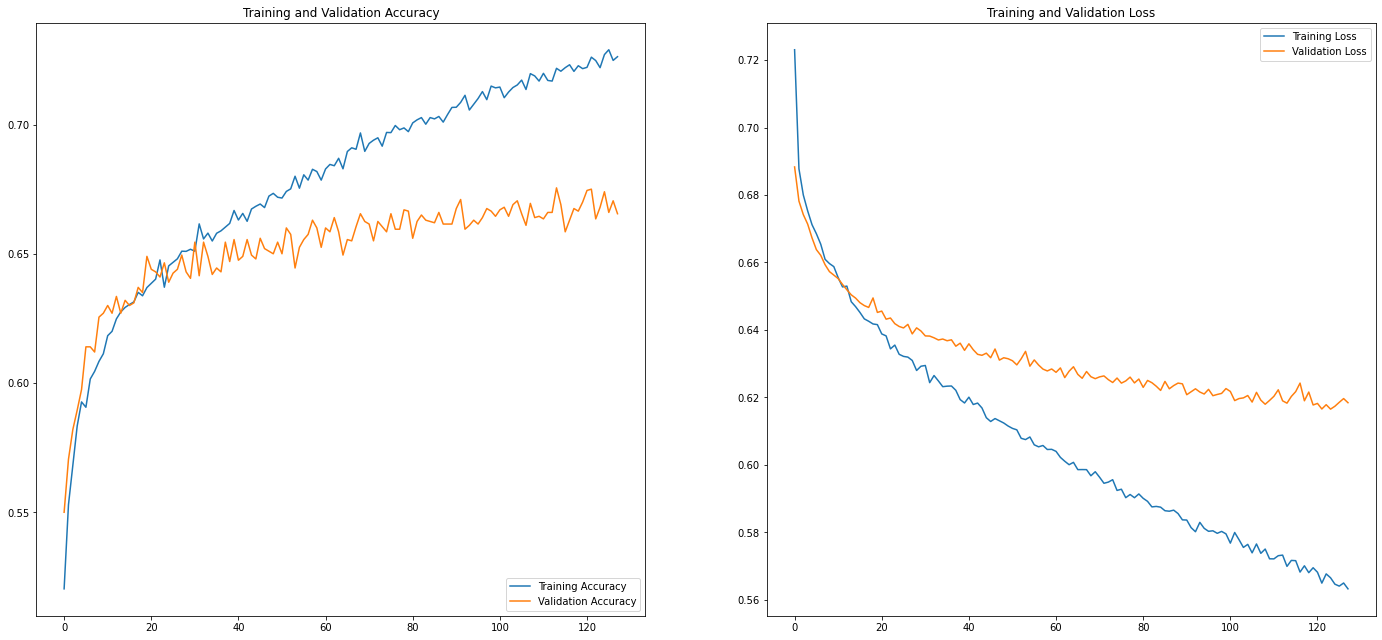

Epoch 1/128
160/160 - 3s - loss: 0.7533 - accuracy: 0.5033 - val_loss: 0.6987 - val_accuracy: 0.5410
Epoch 2/128
160/160 - 2s - loss: 0.6982 - accuracy: 0.5296 - val_loss: 0.6852 - val_accuracy: 0.5610
Epoch 3/128
160/160 - 2s - loss: 0.6874 - accuracy: 0.5506 - val_loss: 0.6824 - val_accuracy: 0.5650
Epoch 4/128
160/160 - 2s - loss: 0.6833 - accuracy: 0.5599 - val_loss: 0.6792 - val_accuracy: 0.5795
Epoch 5/128
160/160 - 2s - loss: 0.6815 - accuracy: 0.5664 - val_loss: 0.6781 - val_accuracy: 0.5815
Epoch 6/128
160/160 - 2s - loss: 0.6778 - accuracy: 0.5733 - val_loss: 0.6742 - val_accuracy: 0.5875
Epoch 7/128
160/160 - 2s - loss: 0.6767 - accuracy: 0.5806 - val_loss: 0.6725 - val_accuracy: 0.5940
Epoch 8/128
160/160 - 2s - loss: 0.6743 - accuracy: 0.5857 - val_loss: 0.6704 - val_accuracy: 0.6070
Epoch 9/128
160/160 - 2s - loss: 0.6717 - accuracy: 0.5887 - val_loss: 0.6691 - val_accuracy: 0.6035
Epoch 10/128
160/160 - 2s - loss: 0.6686 - accuracy: 0.5954 - val_loss: 0.6677 - val_accura

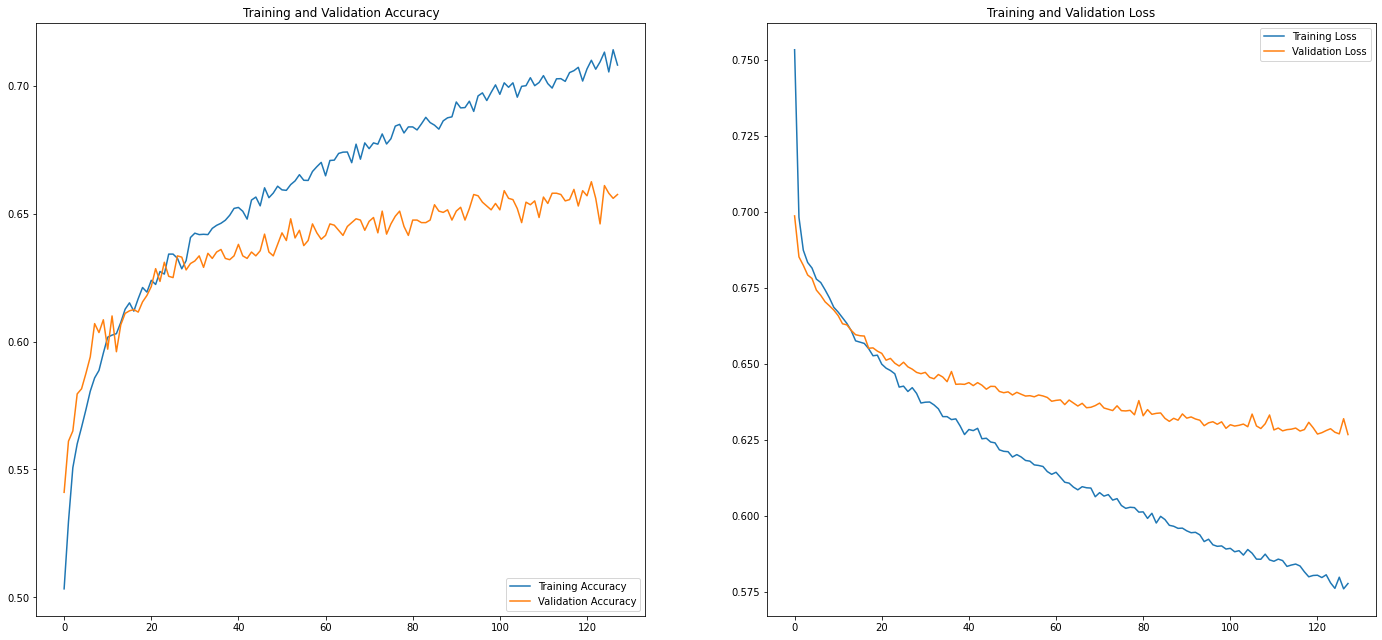

Epoch 1/128
40/40 - 2s - loss: 0.7713 - accuracy: 0.4912 - val_loss: 0.7109 - val_accuracy: 0.5115
Epoch 2/128
40/40 - 2s - loss: 0.7204 - accuracy: 0.5151 - val_loss: 0.7004 - val_accuracy: 0.5430
Epoch 3/128
40/40 - 2s - loss: 0.7028 - accuracy: 0.5267 - val_loss: 0.6912 - val_accuracy: 0.5505
Epoch 4/128
40/40 - 2s - loss: 0.6940 - accuracy: 0.5397 - val_loss: 0.6872 - val_accuracy: 0.5600
Epoch 5/128
40/40 - 2s - loss: 0.6908 - accuracy: 0.5513 - val_loss: 0.6849 - val_accuracy: 0.5675
Epoch 6/128
40/40 - 2s - loss: 0.6872 - accuracy: 0.5584 - val_loss: 0.6826 - val_accuracy: 0.5775
Epoch 7/128
40/40 - 2s - loss: 0.6856 - accuracy: 0.5609 - val_loss: 0.6801 - val_accuracy: 0.5660
Epoch 8/128
40/40 - 2s - loss: 0.6829 - accuracy: 0.5703 - val_loss: 0.6783 - val_accuracy: 0.5865
Epoch 9/128
40/40 - 2s - loss: 0.6805 - accuracy: 0.5767 - val_loss: 0.6761 - val_accuracy: 0.5880
Epoch 10/128
40/40 - 2s - loss: 0.6793 - accuracy: 0.5756 - val_loss: 0.6743 - val_accuracy: 0.5915
Epoch 11/

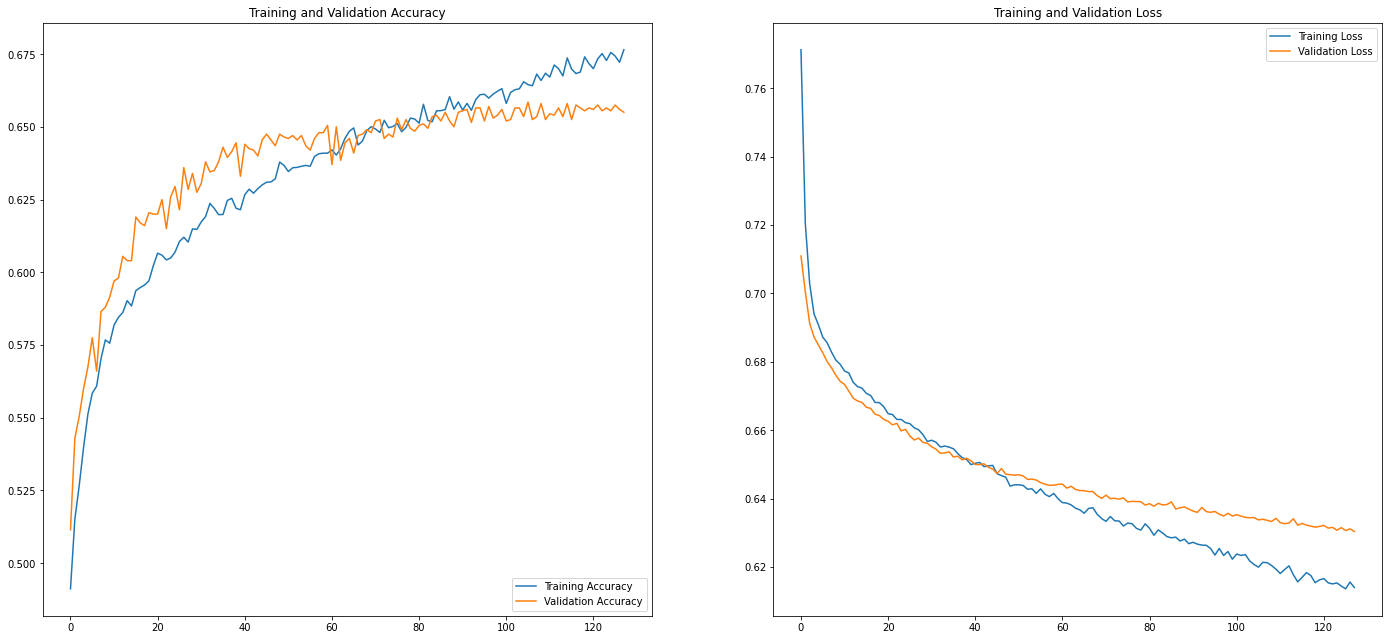

Epoch 1/128
23/23 - 2s - loss: 0.7687 - accuracy: 0.5009 - val_loss: 0.7101 - val_accuracy: 0.5150
Epoch 2/128
23/23 - 2s - loss: 0.7255 - accuracy: 0.5044 - val_loss: 0.7013 - val_accuracy: 0.5460
Epoch 3/128
23/23 - 2s - loss: 0.7176 - accuracy: 0.5099 - val_loss: 0.6981 - val_accuracy: 0.5460
Epoch 4/128
23/23 - 2s - loss: 0.7112 - accuracy: 0.5135 - val_loss: 0.6948 - val_accuracy: 0.5540
Epoch 5/128
23/23 - 2s - loss: 0.7072 - accuracy: 0.5158 - val_loss: 0.6916 - val_accuracy: 0.5645
Epoch 6/128
23/23 - 2s - loss: 0.7035 - accuracy: 0.5169 - val_loss: 0.6891 - val_accuracy: 0.5670
Epoch 7/128
23/23 - 2s - loss: 0.6969 - accuracy: 0.5289 - val_loss: 0.6866 - val_accuracy: 0.5710
Epoch 8/128
23/23 - 2s - loss: 0.6926 - accuracy: 0.5361 - val_loss: 0.6839 - val_accuracy: 0.5790
Epoch 9/128
23/23 - 2s - loss: 0.6904 - accuracy: 0.5458 - val_loss: 0.6825 - val_accuracy: 0.5810
Epoch 10/128
23/23 - 2s - loss: 0.6889 - accuracy: 0.5435 - val_loss: 0.6812 - val_accuracy: 0.5815
Epoch 11/

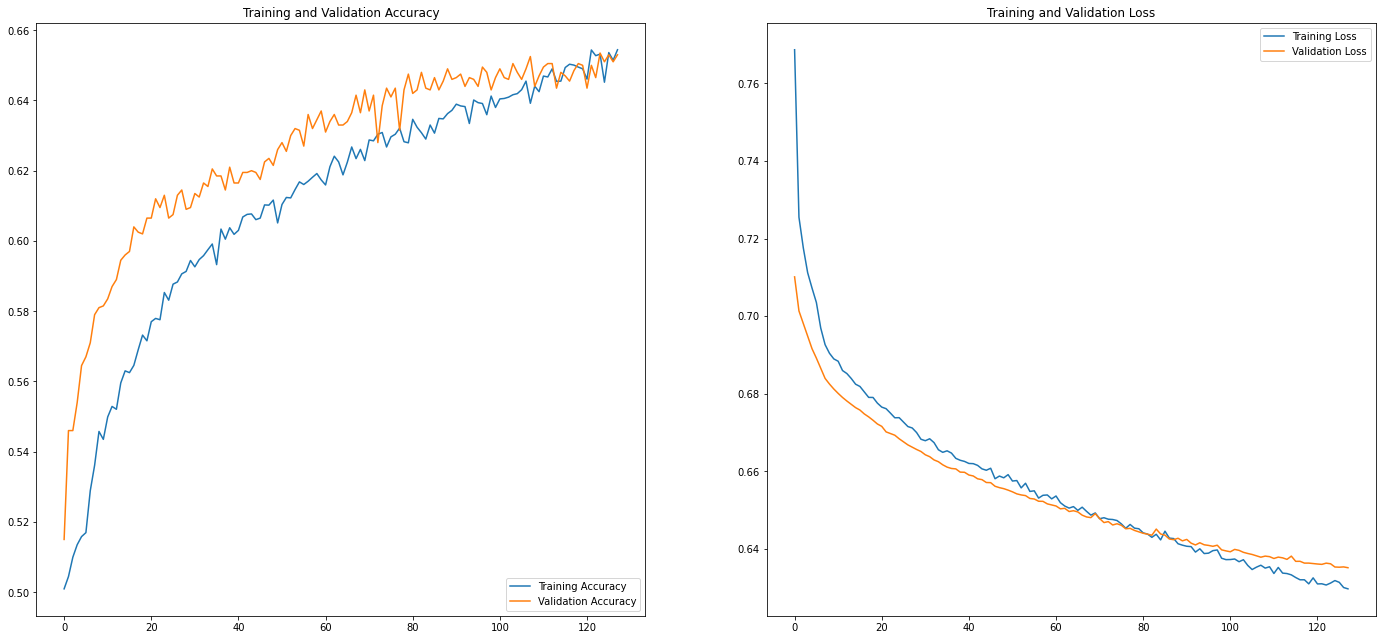

Epoch 1/128
16/16 - 3s - loss: 0.7592 - accuracy: 0.5014 - val_loss: 0.7200 - val_accuracy: 0.5140
Epoch 2/128
16/16 - 2s - loss: 0.7302 - accuracy: 0.5115 - val_loss: 0.7053 - val_accuracy: 0.5330
Epoch 3/128
16/16 - 2s - loss: 0.7186 - accuracy: 0.5165 - val_loss: 0.6985 - val_accuracy: 0.5385
Epoch 4/128
16/16 - 2s - loss: 0.7126 - accuracy: 0.5207 - val_loss: 0.6936 - val_accuracy: 0.5565
Epoch 5/128
16/16 - 2s - loss: 0.7033 - accuracy: 0.5275 - val_loss: 0.6897 - val_accuracy: 0.5570
Epoch 6/128
16/16 - 2s - loss: 0.6994 - accuracy: 0.5304 - val_loss: 0.6866 - val_accuracy: 0.5605
Epoch 7/128
16/16 - 2s - loss: 0.6927 - accuracy: 0.5487 - val_loss: 0.6845 - val_accuracy: 0.5630
Epoch 8/128
16/16 - 2s - loss: 0.6921 - accuracy: 0.5446 - val_loss: 0.6830 - val_accuracy: 0.5595
Epoch 9/128
16/16 - 2s - loss: 0.6896 - accuracy: 0.5509 - val_loss: 0.6817 - val_accuracy: 0.5705
Epoch 10/128
16/16 - 2s - loss: 0.6877 - accuracy: 0.5534 - val_loss: 0.6806 - val_accuracy: 0.5710
Epoch 11/

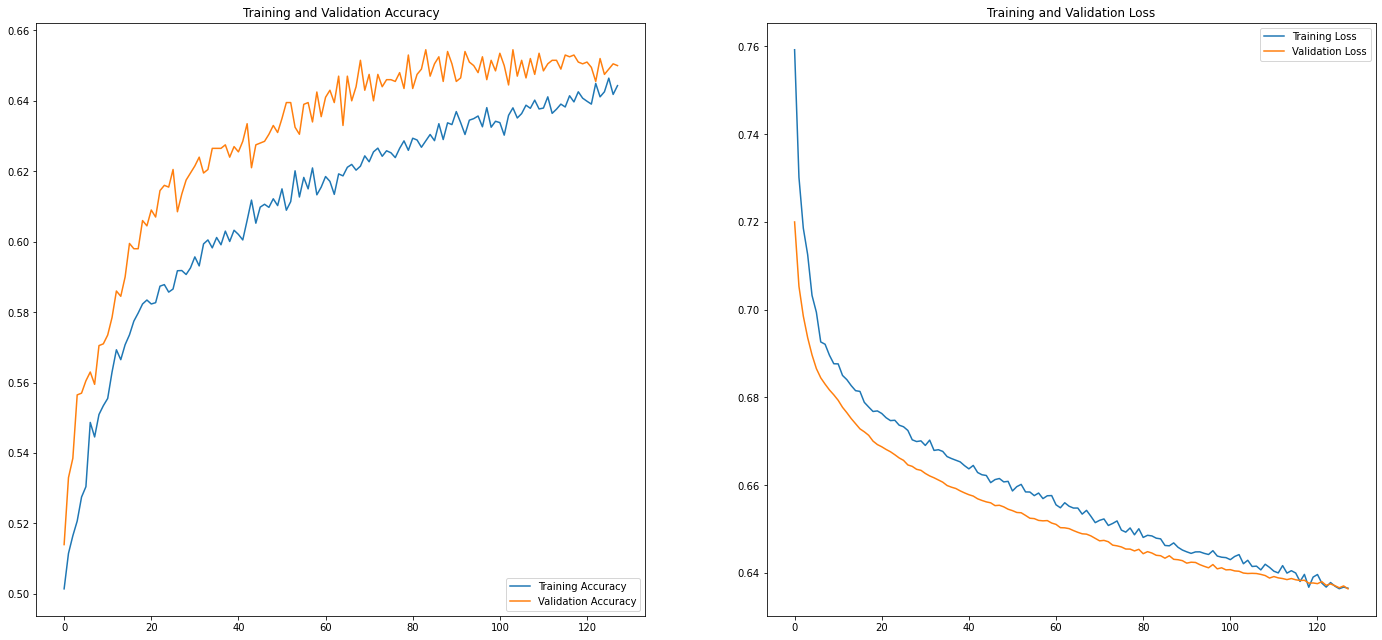

In [ ]:
batches = [64, 100, 400, 700, 1000]

for i in batches:
  model = Sequential()
  model.add(Flatten(input_shape=(134,120,3)))
  model.add(Dense(50, activation="relu",activity_regularizer=l1(0.001)))
  model.add(Dropout(0.2))
  model.add(Dense(2, activation="softmax"))

  opt = Adam(learning_rate=0.000001)
  model.compile(optimizer = opt , loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True) , metrics = ['accuracy'])
  history = model.fit(x_train,y_train,epochs = 128 ,batch_size=i, validation_data = (x_val, y_val), verbose=2)

  print(f"Batch size = {i}")
  acc = history.history['accuracy']
  val_acc = history.history['val_accuracy']
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  epochs_range = range(128)

  plt.figure(figsize=(24, 24))
  plt.subplot(2, 2, 1)
  plt.plot(epochs_range, acc, label='Training Accuracy')
  plt.plot(epochs_range, val_acc, label='Validation Accuracy')
  plt.legend(loc='lower right')
  plt.title('Training and Validation Accuracy')

  plt.subplot(2, 2, 2)
  plt.plot(epochs_range, loss, label='Training Loss')
  plt.plot(epochs_range, val_loss, label='Validation Loss')
  plt.legend(loc='upper right')
  plt.title('Training and Validation Loss')
  plt.show()

##  **ج)** 

### ***Impact Of Number of Neurons on Convergence and Generalization:***

Epoch 1/128


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/backend.py:4930: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  '"`sparse_categorical_crossentropy` received `from_logits=True`, but '


250/250 - 3s - loss: 0.7176 - accuracy: 0.5184 - val_loss: 0.6925 - val_accuracy: 0.5360
Epoch 2/128
250/250 - 2s - loss: 0.6896 - accuracy: 0.5493 - val_loss: 0.6860 - val_accuracy: 0.5570
Epoch 3/128
250/250 - 2s - loss: 0.6853 - accuracy: 0.5611 - val_loss: 0.6829 - val_accuracy: 0.5630
Epoch 4/128
250/250 - 2s - loss: 0.6809 - accuracy: 0.5742 - val_loss: 0.6794 - val_accuracy: 0.5865
Epoch 5/128
250/250 - 2s - loss: 0.6764 - accuracy: 0.5828 - val_loss: 0.6777 - val_accuracy: 0.5895
Epoch 6/128
250/250 - 2s - loss: 0.6728 - accuracy: 0.5888 - val_loss: 0.6732 - val_accuracy: 0.5940
Epoch 7/128
250/250 - 2s - loss: 0.6691 - accuracy: 0.5960 - val_loss: 0.6705 - val_accuracy: 0.6070
Epoch 8/128
250/250 - 2s - loss: 0.6664 - accuracy: 0.6039 - val_loss: 0.6689 - val_accuracy: 0.6045
Epoch 9/128
250/250 - 2s - loss: 0.6643 - accuracy: 0.6055 - val_loss: 0.6660 - val_accuracy: 0.6145
Epoch 10/128
250/250 - 2s - loss: 0.6634 - accuracy: 0.6028 - val_loss: 0.6637 - val_accuracy: 0.6130
E

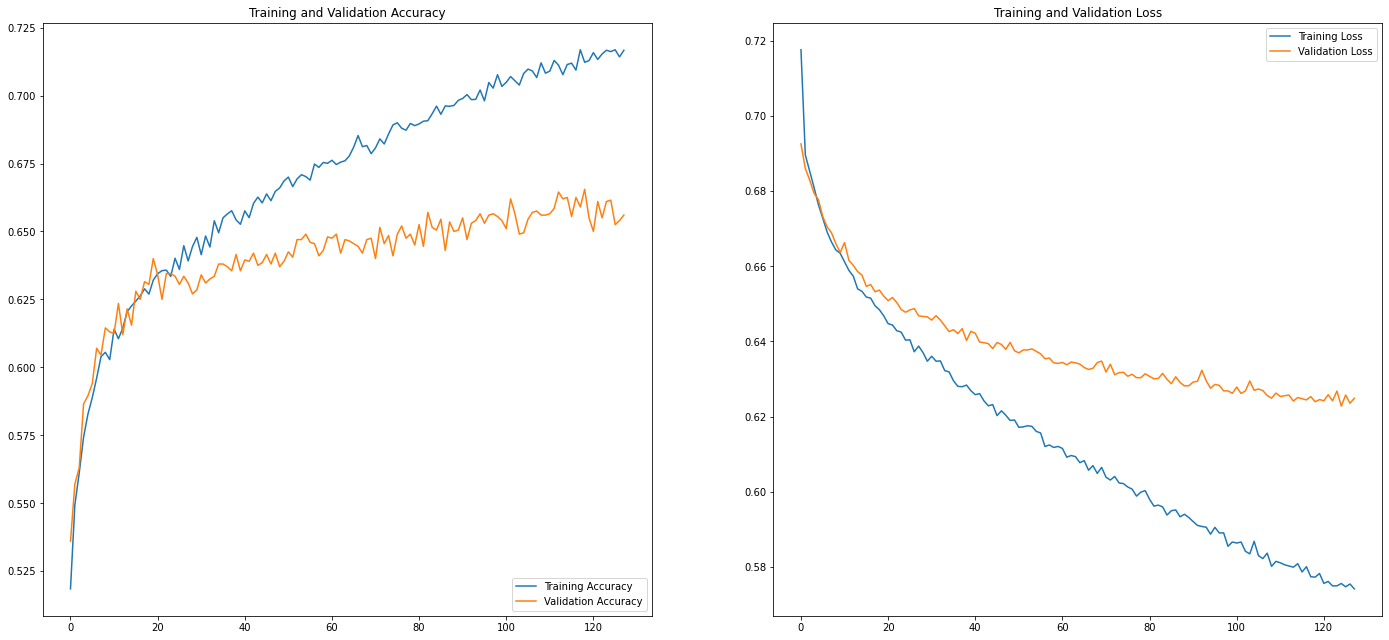

Epoch 1/128
250/250 - 3s - loss: 0.7467 - accuracy: 0.5376 - val_loss: 0.6957 - val_accuracy: 0.5730
Epoch 2/128
250/250 - 2s - loss: 0.6888 - accuracy: 0.5718 - val_loss: 0.6785 - val_accuracy: 0.5895
Epoch 3/128
250/250 - 2s - loss: 0.6756 - accuracy: 0.5932 - val_loss: 0.6704 - val_accuracy: 0.6050
Epoch 4/128
250/250 - 2s - loss: 0.6695 - accuracy: 0.6037 - val_loss: 0.6666 - val_accuracy: 0.6140
Epoch 5/128
250/250 - 2s - loss: 0.6648 - accuracy: 0.6096 - val_loss: 0.6686 - val_accuracy: 0.6150
Epoch 6/128
250/250 - 2s - loss: 0.6625 - accuracy: 0.6127 - val_loss: 0.6612 - val_accuracy: 0.6185
Epoch 7/128
250/250 - 2s - loss: 0.6580 - accuracy: 0.6237 - val_loss: 0.6582 - val_accuracy: 0.6290
Epoch 8/128
250/250 - 2s - loss: 0.6553 - accuracy: 0.6279 - val_loss: 0.6565 - val_accuracy: 0.6255
Epoch 9/128
250/250 - 2s - loss: 0.6523 - accuracy: 0.6293 - val_loss: 0.6551 - val_accuracy: 0.6210
Epoch 10/128
250/250 - 2s - loss: 0.6497 - accuracy: 0.6313 - val_loss: 0.6540 - val_accura

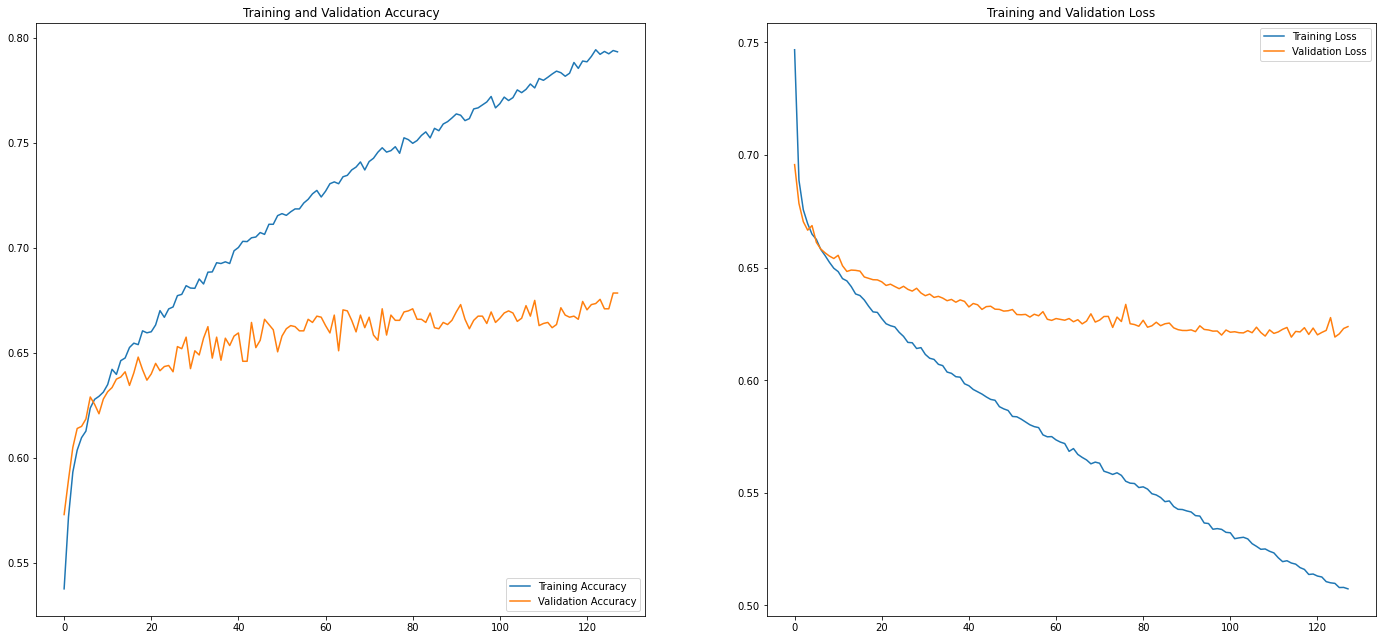

Epoch 1/128
250/250 - 3s - loss: 0.7708 - accuracy: 0.5334 - val_loss: 0.6987 - val_accuracy: 0.5770
Epoch 2/128
250/250 - 2s - loss: 0.6908 - accuracy: 0.5792 - val_loss: 0.6795 - val_accuracy: 0.6020
Epoch 3/128
250/250 - 2s - loss: 0.6757 - accuracy: 0.5984 - val_loss: 0.6738 - val_accuracy: 0.6075
Epoch 4/128
250/250 - 2s - loss: 0.6709 - accuracy: 0.6024 - val_loss: 0.6713 - val_accuracy: 0.6070
Epoch 5/128
250/250 - 2s - loss: 0.6642 - accuracy: 0.6175 - val_loss: 0.6672 - val_accuracy: 0.6265
Epoch 6/128
250/250 - 2s - loss: 0.6614 - accuracy: 0.6187 - val_loss: 0.6662 - val_accuracy: 0.6295
Epoch 7/128
250/250 - 2s - loss: 0.6577 - accuracy: 0.6269 - val_loss: 0.6626 - val_accuracy: 0.6320
Epoch 8/128
250/250 - 2s - loss: 0.6539 - accuracy: 0.6317 - val_loss: 0.6602 - val_accuracy: 0.6255
Epoch 9/128
250/250 - 2s - loss: 0.6510 - accuracy: 0.6346 - val_loss: 0.6590 - val_accuracy: 0.6375
Epoch 10/128
250/250 - 2s - loss: 0.6474 - accuracy: 0.6426 - val_loss: 0.6574 - val_accura

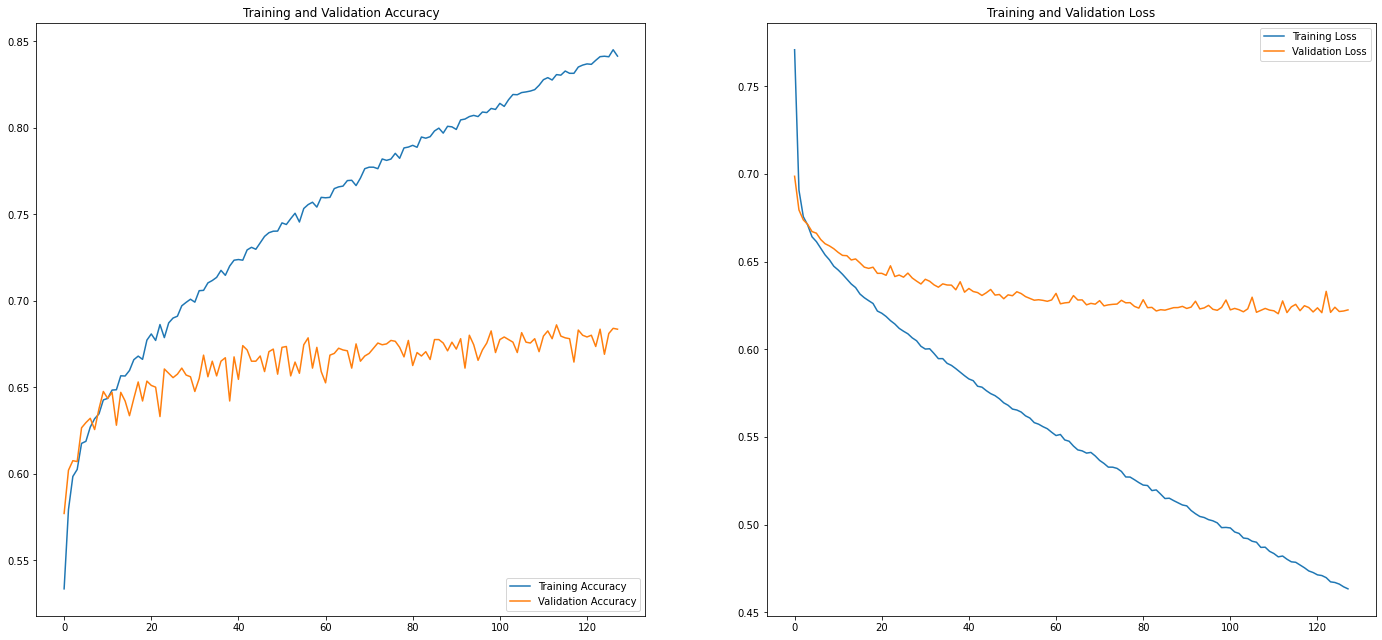

In [ ]:
nums = [50, 250, 512]

for i in nums:
  model = Sequential()
  model.add(Flatten(input_shape=(134,120,3)))
  model.add(Dense(i, activation="relu",activity_regularizer=l1(0.001)))
  model.add(Dropout(0.2))
  model.add(Dense(2, activation="softmax"))

  opt = Adam(learning_rate=0.000001)
  model.compile(optimizer = opt , loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True) , metrics = ['accuracy'])
  history = model.fit(x_train,y_train,epochs = 128 ,batch_size=64, validation_data = (x_val, y_val), verbose=2)

  print(f"Neurons num = {i}")
  acc = history.history['accuracy']
  val_acc = history.history['val_accuracy']
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  epochs_range = range(128)

  plt.figure(figsize=(24, 24))
  plt.subplot(2, 2, 1)
  plt.plot(epochs_range, acc, label='Training Accuracy')
  plt.plot(epochs_range, val_acc, label='Validation Accuracy')
  plt.legend(loc='lower right')
  plt.title('Training and Validation Accuracy')

  plt.subplot(2, 2, 2)
  plt.plot(epochs_range, loss, label='Training Loss')
  plt.plot(epochs_range, val_loss, label='Validation Loss')
  plt.legend(loc='upper right')
  plt.title('Training and Validation Loss')
  plt.show()

### ***Impact Of Number of Layers on Convergence and Generalization:***

Epoch 1/128


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/backend.py:4930: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  '"`sparse_categorical_crossentropy` received `from_logits=True`, but '


250/250 - 3s - loss: 0.7152 - accuracy: 0.5154 - val_loss: 0.6906 - val_accuracy: 0.5565
Epoch 2/128
250/250 - 2s - loss: 0.6874 - accuracy: 0.5509 - val_loss: 0.6844 - val_accuracy: 0.5485
Epoch 3/128
250/250 - 2s - loss: 0.6828 - accuracy: 0.5667 - val_loss: 0.6783 - val_accuracy: 0.5865
Epoch 4/128
250/250 - 2s - loss: 0.6783 - accuracy: 0.5763 - val_loss: 0.6748 - val_accuracy: 0.5815
Epoch 5/128
250/250 - 2s - loss: 0.6736 - accuracy: 0.5839 - val_loss: 0.6729 - val_accuracy: 0.5945
Epoch 6/128
250/250 - 2s - loss: 0.6695 - accuracy: 0.5922 - val_loss: 0.6680 - val_accuracy: 0.6040
Epoch 7/128
250/250 - 2s - loss: 0.6679 - accuracy: 0.5971 - val_loss: 0.6684 - val_accuracy: 0.6065
Epoch 8/128
250/250 - 2s - loss: 0.6653 - accuracy: 0.5987 - val_loss: 0.6676 - val_accuracy: 0.6095
Epoch 9/128
250/250 - 2s - loss: 0.6636 - accuracy: 0.6013 - val_loss: 0.6640 - val_accuracy: 0.6150
Epoch 10/128
250/250 - 2s - loss: 0.6617 - accuracy: 0.6071 - val_loss: 0.6610 - val_accuracy: 0.6140
E

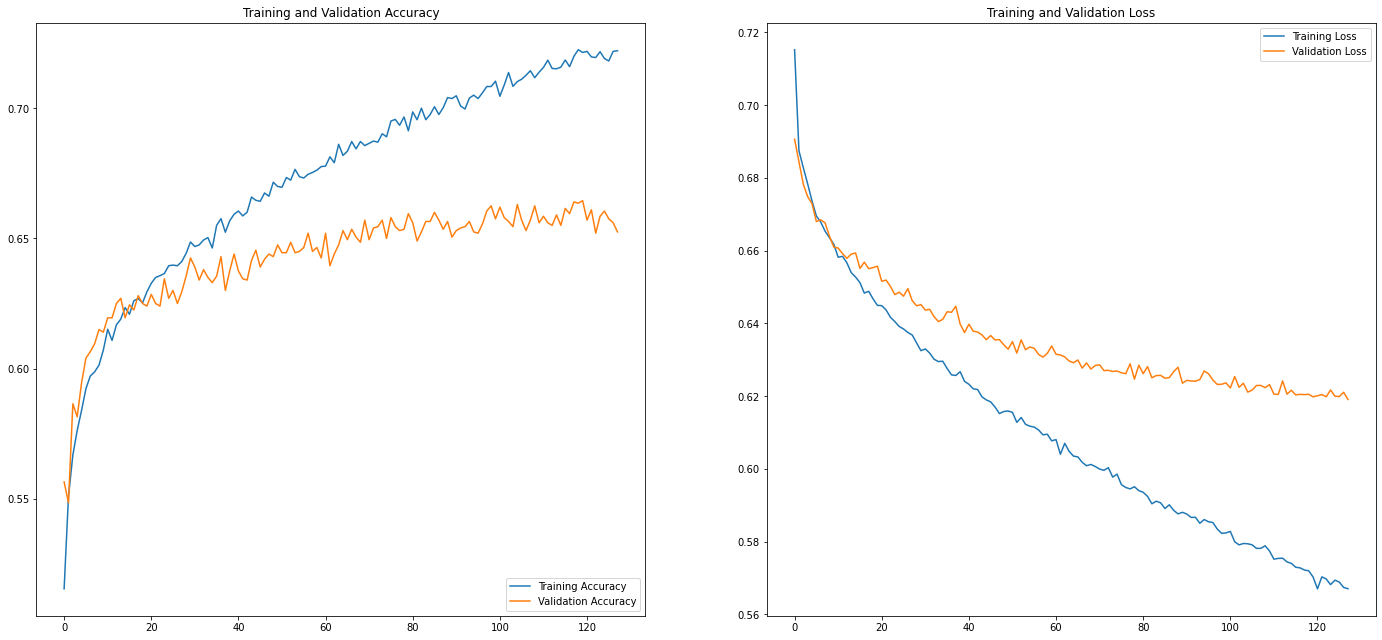

Epoch 1/128
250/250 - 3s - loss: 0.7042 - accuracy: 0.5206 - val_loss: 0.6934 - val_accuracy: 0.5525
Epoch 2/128
250/250 - 2s - loss: 0.6922 - accuracy: 0.5518 - val_loss: 0.6884 - val_accuracy: 0.5625
Epoch 3/128
250/250 - 2s - loss: 0.6887 - accuracy: 0.5598 - val_loss: 0.6852 - val_accuracy: 0.5745
Epoch 4/128
250/250 - 2s - loss: 0.6844 - accuracy: 0.5772 - val_loss: 0.6831 - val_accuracy: 0.5860
Epoch 5/128
250/250 - 2s - loss: 0.6821 - accuracy: 0.5898 - val_loss: 0.6807 - val_accuracy: 0.5875
Epoch 6/128
250/250 - 2s - loss: 0.6800 - accuracy: 0.5904 - val_loss: 0.6791 - val_accuracy: 0.6000
Epoch 7/128
250/250 - 2s - loss: 0.6777 - accuracy: 0.5956 - val_loss: 0.6775 - val_accuracy: 0.5945
Epoch 8/128
250/250 - 2s - loss: 0.6756 - accuracy: 0.5976 - val_loss: 0.6765 - val_accuracy: 0.5995
Epoch 9/128
250/250 - 2s - loss: 0.6745 - accuracy: 0.6016 - val_loss: 0.6754 - val_accuracy: 0.6025
Epoch 10/128
250/250 - 2s - loss: 0.6727 - accuracy: 0.6018 - val_loss: 0.6750 - val_accura

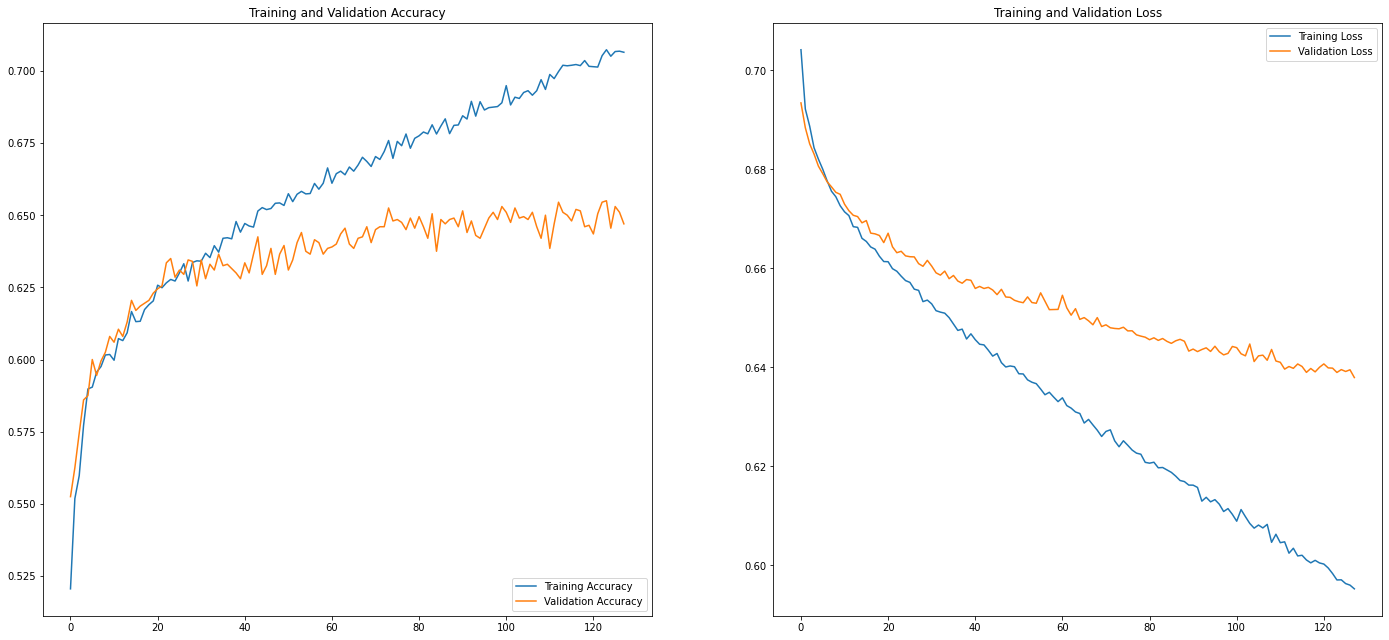

Epoch 1/128
250/250 - 6s - loss: 0.7099 - accuracy: 0.5251 - val_loss: 0.6958 - val_accuracy: 0.5215
Epoch 2/128
250/250 - 2s - loss: 0.6940 - accuracy: 0.5454 - val_loss: 0.6914 - val_accuracy: 0.5455
Epoch 3/128
250/250 - 2s - loss: 0.6917 - accuracy: 0.5543 - val_loss: 0.6906 - val_accuracy: 0.5575
Epoch 4/128
250/250 - 2s - loss: 0.6906 - accuracy: 0.5546 - val_loss: 0.6894 - val_accuracy: 0.5590
Epoch 5/128
250/250 - 2s - loss: 0.6891 - accuracy: 0.5626 - val_loss: 0.6887 - val_accuracy: 0.5760
Epoch 6/128
250/250 - 2s - loss: 0.6880 - accuracy: 0.5704 - val_loss: 0.6867 - val_accuracy: 0.5680
Epoch 7/128
250/250 - 2s - loss: 0.6865 - accuracy: 0.5753 - val_loss: 0.6861 - val_accuracy: 0.5860
Epoch 8/128
250/250 - 2s - loss: 0.6856 - accuracy: 0.5761 - val_loss: 0.6846 - val_accuracy: 0.5920
Epoch 9/128
250/250 - 2s - loss: 0.6840 - accuracy: 0.5893 - val_loss: 0.6840 - val_accuracy: 0.5930
Epoch 10/128
250/250 - 2s - loss: 0.6825 - accuracy: 0.5964 - val_loss: 0.6830 - val_accura

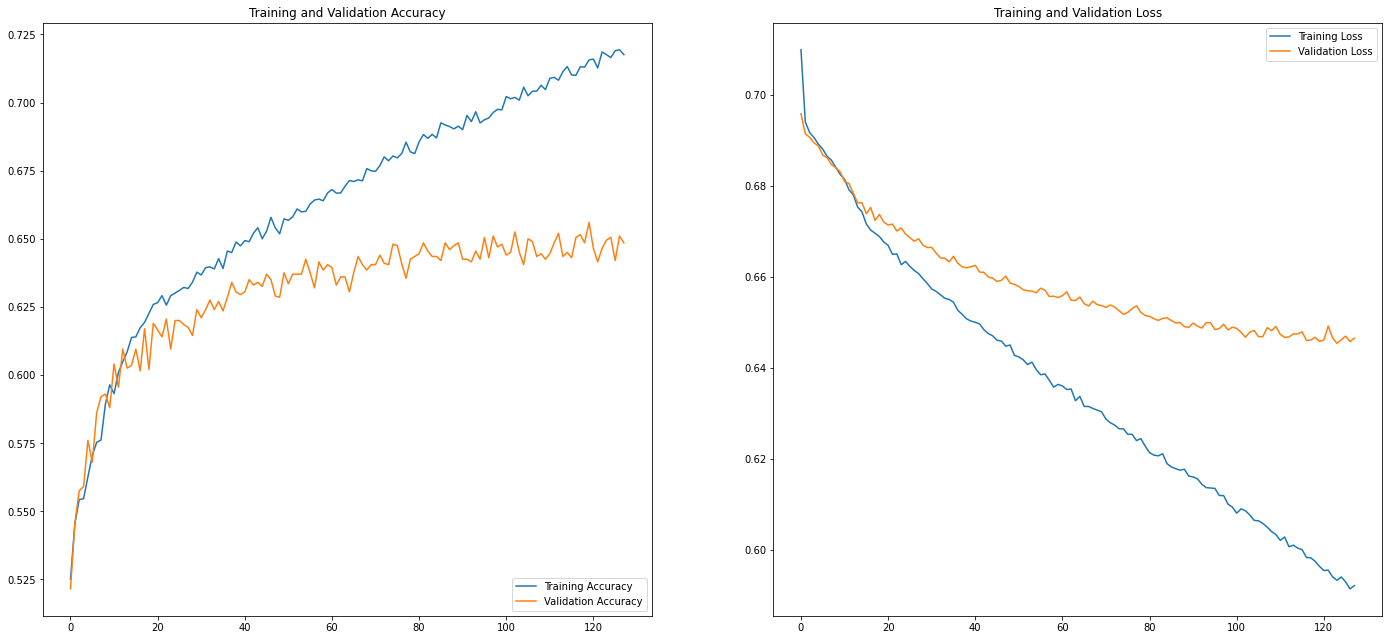

In [ ]:
model = Sequential()
model.add(Flatten(input_shape=(134,120,3)))
model.add(Dense(50, activation="relu",activity_regularizer=l1(0.001)))
model.add(Dropout(0.2))
model.add(Dense(2, activation="softmax"))

opt = Adam(learning_rate=0.000001)
model.compile(optimizer = opt , loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True) , metrics = ['accuracy'])
history = model.fit(x_train,y_train,epochs = 128 ,batch_size=64, validation_data = (x_val, y_val), verbose=2)

print("1 Layer:")
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(128)

plt.figure(figsize=(24, 24))
plt.subplot(2, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()



########################################
model = Sequential()
model.add(Flatten(input_shape=(134,120,3)))
model.add(Dense(50, activation="relu",activity_regularizer=l1(0.001)))
model.add(Dense(50, activation="relu",activity_regularizer=l1(0.001)))
model.add(Dropout(0.2))
model.add(Dense(2, activation="softmax"))

opt = Adam(learning_rate=0.000001)
model.compile(optimizer = opt , loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True) , metrics = ['accuracy'])
history = model.fit(x_train,y_train,epochs = 128 ,batch_size=64, validation_data = (x_val, y_val), verbose=2)

print("2 Layer:")
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(128)

plt.figure(figsize=(24, 24))
plt.subplot(2, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()



##################################################
########################################
model = Sequential()
model.add(Flatten(input_shape=(134,120,3)))
model.add(Dense(50, activation="relu",activity_regularizer=l1(0.001)))
model.add(Dense(50, activation="relu",activity_regularizer=l1(0.001)))
model.add(Dense(50, activation="relu",activity_regularizer=l1(0.001)))
model.add(Dropout(0.2))
model.add(Dense(2, activation="softmax"))

opt = Adam(learning_rate=0.000001)
model.compile(optimizer = opt , loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True) , metrics = ['accuracy'])
history = model.fit(x_train,y_train,epochs = 128 ,batch_size=64, validation_data = (x_val, y_val), verbose=2)

print("3 Layer:")
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(128)

plt.figure(figsize=(24, 24))
plt.subplot(2, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

##  **د)** 

In [10]:
train_datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range = 30,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.2, # Randomly zoom image 
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip = True,  # randomly flip images
        vertical_flip=True)  # randomly flip images


train_generator = train_datagen.flow(x_train, y_train)

x_train_gen = []
y_train_gen = []
train_generator.reset()
print(train_generator.__len__())
for i in range(train_generator.__len__()):
   a, b = train_generator.next()
   x_train_gen.append(a)
   y_train_gen.append(b)
x_train_gen=np.array(x_train_gen)
y_train_gen=np.array(y_train_gen)
print(x_train_gen.shape)
print(y_train_gen.shape)

500
(500, 32, 134, 120, 3)
(500, 32)


In [13]:
# y_train_gen = y_train_gen.reshape(500*32,)
# x_train_gen = x_train_gen.reshape(500*32, 134, 120, 3)
x_train = np.concatenate((x_train, x_train_gen[0:4000]))
y_train = np.concatenate((y_train, y_train_gen[0:4000]))

In [ ]:

x_train = np.append(x_train, x_train[4000:], axis=0)
y_train = np.append(y_train, y_train[4000:5000], axis=0)

Epoch 1/128


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/backend.py:4930: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  '"`sparse_categorical_crossentropy` received `from_logits=True`, but '


266/266 [==============================] - 3s 9ms/step - loss: 0.7332 - accuracy: 0.5109 - val_loss: 0.6897 - val_accuracy: 0.5450
Epoch 2/128
266/266 [==============================] - 2s 8ms/step - loss: 0.6866 - accuracy: 0.5614 - val_loss: 0.6802 - val_accuracy: 0.5750
Epoch 3/128
266/266 [==============================] - 2s 8ms/step - loss: 0.6786 - accuracy: 0.5806 - val_loss: 0.6783 - val_accuracy: 0.5835
Epoch 4/128
266/266 [==============================] - 2s 8ms/step - loss: 0.6761 - accuracy: 0.5835 - val_loss: 0.6739 - val_accuracy: 0.5930
Epoch 5/128
266/266 [==============================] - 2s 9ms/step - loss: 0.6676 - accuracy: 0.5974 - val_loss: 0.6710 - val_accuracy: 0.5950
Epoch 6/128
266/266 [==============================] - 2s 8ms/step - loss: 0.6672 - accuracy: 0.6100 - val_loss: 0.6666 - val_accuracy: 0.6070
Epoch 7/128
266/266 [==============================] - 2s 9ms/step - loss: 0.6666 - accuracy: 0.5987 - val_loss: 0.6674 - val_accuracy: 0.5980
Epoch 8/128

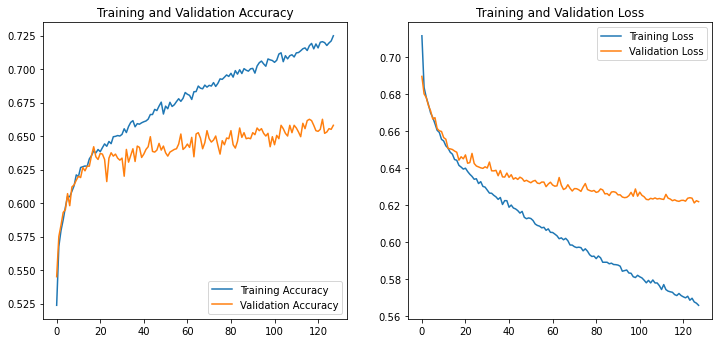

In [ ]:
new_model = Sequential()
new_model.add(Flatten(input_shape=(134,120,3)))
new_model.add(Dense(50, activation="relu",activity_regularizer=l1(0.001)))
new_model.add(Dropout(0.2))
new_model.add(Dense(2, activation="softmax"))

opt = Adam(learning_rate=0.000001)
new_model.compile(optimizer = opt , loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True) , metrics = ['accuracy'])
history = new_model.fit(x_train,y_train,epochs = 128 ,batch_size=64, validation_data = (x_val, y_val))

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(128)

plt.figure(figsize=(12, 12))
plt.subplot(2, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [17]:
# preds = model.predict(x_val)
preds = new_model.predict(x_val)

print(preds.shape)

# not_sures=[]
# for i in range(0,2000):
#   if preds[i][predictions[i]]<0.1:
#     not_sures.append(i)
# slc = not_sures[1:3]

(2000, 2)


In [18]:
wrongs = []

for z in range(2000):
  if y_val[z] != preds[z].argmax():
    wrongs.append(z)

wrongs = np.array(wrongs)

In [19]:
wdog = []
wcat = []
for i in wrongs:
  if y_val[i] == 0:
    wcat.append(i)
  else:
    wdog.append(i)

In [20]:
print(len(wcat))
print(len(wdog))


350
315


In [21]:
limmit = 0.2
weaks = []
for i in wrongs:
  if preds[i][y_val[i]] < limmit:
    weaks.append(i)

weaks = np.array(weaks)

In [22]:
weakdog = []
weakcat = []
for i in weaks:
  if y_val[i] == 0:
    weakcat.append(i)
  else:
    weakdog.append(i)

In [23]:
print(len(weakcat))
print(len(weakdog))


14
14


[0.1587025 0.8412975]


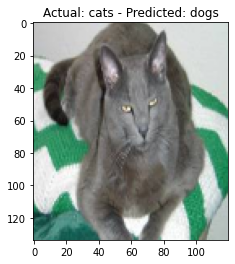

[0.18851677 0.8114832 ]


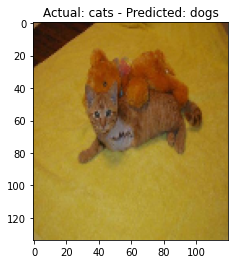

[0.8507469  0.14925304]


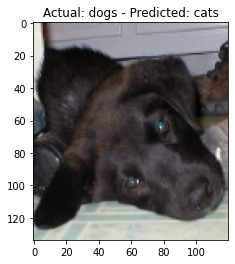

[0.8079768  0.19202322]


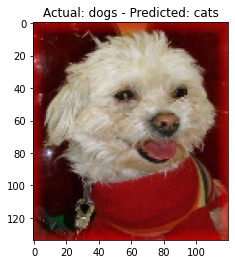

[0.81239974 0.18760028]


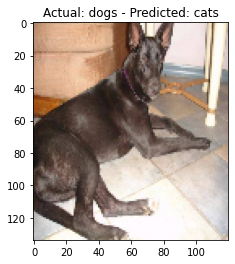

In [ ]:
for i in weaks:
  if i % 5 == 0:
    plt.imshow(x_val[i])
    plt.title(f"Actual: {labels[y_val[i]]} - Predicted: {labels[preds[i].argmax()]}")
    print(preds[i])
    plt.show()

In [ ]:
x_train = []
y_train = []
x_val = []
y_val = []
gc.collect()

11120

##  **ه)** 

### ***Using Transfer learning for CNN***

#### ***MobileNet:***

In [ ]:
base_model= tf.keras.applications.MobileNet(weights='imagenet',input_shape = (128, 128, 3))

In [ ]:
x=base_model.output
x=tf.keras.layers.Dense(1024,activation='relu')(x) 
x=tf.keras.layers.Dense(1024,activation='relu')(x)
x=tf.keras.layers.Dense(512,activation='relu')(x) 
preds=tf.keras.layers.Dense(2,activation='softmax')(x) 


In [ ]:
base_model.trainable = False


In [ ]:
model=keras.models.Model(inputs=base_model.input,outputs=preds)

In [ ]:
model.compile(optimizer='Adam',loss='sparse_categorical_crossentropy',metrics=['accuracy'])

In [ ]:
history = model.fit(x_train,y_train,epochs = 25 , validation_data = (x_val, y_val))

Epoch 1/25
500/500 [==============================] - 11s 18ms/step - loss: 0.1900 - accuracy: 0.9251 - val_loss: 0.1220 - val_accuracy: 0.9550
Epoch 2/25
500/500 [==============================] - 8s 16ms/step - loss: 0.1073 - accuracy: 0.9608 - val_loss: 0.1118 - val_accuracy: 0.9630
Epoch 3/25
500/500 [==============================] - 8s 16ms/step - loss: 0.0946 - accuracy: 0.9651 - val_loss: 0.1165 - val_accuracy: 0.9655
Epoch 4/25
500/500 [==============================] - 8s 16ms/step - loss: 0.0759 - accuracy: 0.9717 - val_loss: 0.1214 - val_accuracy: 0.9595
Epoch 5/25
500/500 [==============================] - 8s 16ms/step - loss: 0.0634 - accuracy: 0.9772 - val_loss: 0.1805 - val_accuracy: 0.9620
Epoch 6/25
500/500 [==============================] - 8s 16ms/step - loss: 0.0557 - accuracy: 0.9781 - val_loss: 0.1670 - val_accuracy: 0.9615
Epoch 7/25
500/500 [==============================] - 8s 16ms/step - loss: 0.0518 - accuracy: 0.9803 - val_loss: 0.2000 - val_accuracy: 0.964

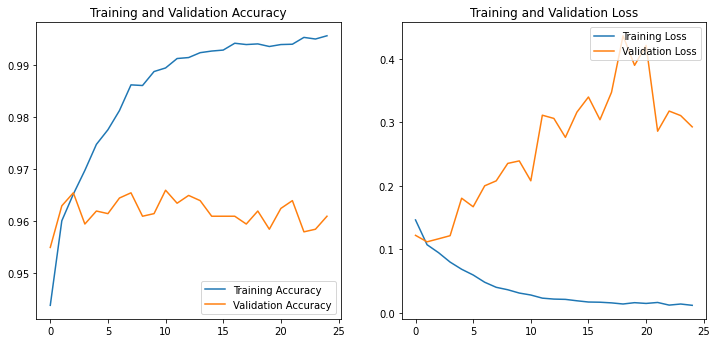

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(25)

plt.figure(figsize=(12, 12))
plt.subplot(2, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [ ]:
model.evaluate(x_val,y_val)

63/63 [==============================] - 1s 16ms/step - loss: 0.2929 - accuracy: 0.9610


[0.2929092347621918, 0.9610000252723694]

In [ ]:
base_model.summary()

Model: "mobilenet_1.00_128"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 128, 128, 3)]     0         
_________________________________________________________________
conv1 (Conv2D)               (None, 64, 64, 32)        864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 64, 64, 32)        128       
_________________________________________________________________
conv1_relu (ReLU)            (None, 64, 64, 32)        0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 64, 64, 32)        288       
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, 64, 64, 32)        128       
_________________________________________________________________
conv_dw_1_relu (ReLU)        (None, 64, 64, 32) 

### ***Hand-designing a CNN***

In [ ]:
#CNN
model = Sequential()
model.add(Conv2D(32,3,padding="same", activation="relu", input_shape=(128,128,3)))
model.add(MaxPool2D())

model.add(Conv2D(32, 3, padding="same", activation="relu"))
model.add(MaxPool2D())

model.add(Conv2D(64, 3, padding="same", activation="relu"))
model.add(MaxPool2D())
model.add(Dropout(0.4))

model.add(Flatten())
model.add(Dense(128,activation="relu"))
model.add(Dense(2, activation="softmax"))

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 128, 128, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 64, 64, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 64, 64, 32)        9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 32, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 16, 16, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 16, 16, 64)        0

In [ ]:
opt = Adam(learning_rate=0.000001)#0.000001
model.compile(optimizer = opt , loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True) , metrics = ['accuracy'])


In [ ]:
history = model.fit(x_train,y_train,epochs = 50 ,batch_size=64, validation_data = (x_val, y_val))

Epoch 1/50
250/250 [==============================] - 9s 35ms/step - loss: 0.6691 - accuracy: 0.6031 - val_loss: 0.6627 - val_accuracy: 0.6065
Epoch 2/50
250/250 [==============================] - 8s 34ms/step - loss: 0.6662 - accuracy: 0.6101 - val_loss: 0.6619 - val_accuracy: 0.5975
Epoch 3/50
250/250 [==============================] - 9s 34ms/step - loss: 0.6654 - accuracy: 0.6122 - val_loss: 0.6597 - val_accuracy: 0.6100
Epoch 4/50
250/250 [==============================] - 8s 34ms/step - loss: 0.6642 - accuracy: 0.6149 - val_loss: 0.6606 - val_accuracy: 0.5910
Epoch 5/50
250/250 [==============================] - 9s 34ms/step - loss: 0.6617 - accuracy: 0.6174 - val_loss: 0.6562 - val_accuracy: 0.6220
Epoch 6/50
250/250 [==============================] - 9s 34ms/step - loss: 0.6604 - accuracy: 0.6206 - val_loss: 0.6529 - val_accuracy: 0.6390
Epoch 7/50
250/250 [==============================] - 9s 34ms/step - loss: 0.6597 - accuracy: 0.6208 - val_loss: 0.6548 - val_accuracy: 0.6085

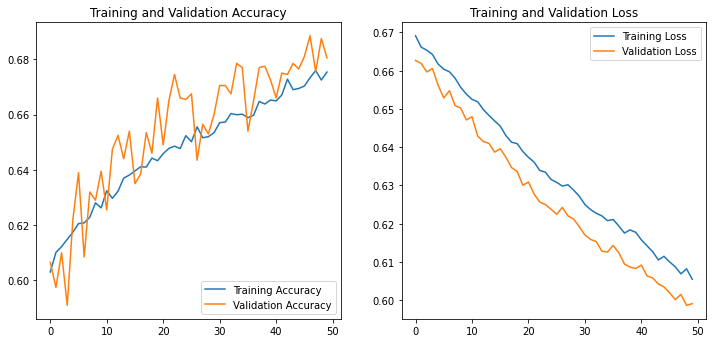

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(50)

plt.figure(figsize=(12, 12))
plt.subplot(2, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [ ]:
predictions = model.predict_classes(x_val)
predictions = predictions.reshape(1,-1)[0]
print(classification_report(y_val, predictions, target_names = ['Cats (Class 0)','Dogs (Class 1)']))

/usr/local/lib/python3.7/dist-packages/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


                precision    recall  f1-score   support

Cats (Class 0)       0.70      0.62      0.66      1000
Dogs (Class 1)       0.66      0.74      0.70      1000

      accuracy                           0.68      2000
     macro avg       0.68      0.68      0.68      2000
  weighted avg       0.68      0.68      0.68      2000

